## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


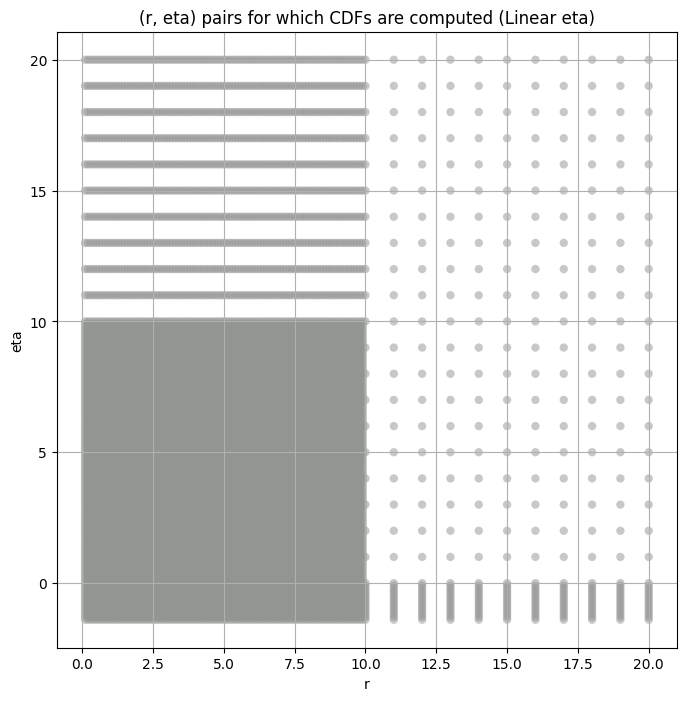

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7180.381000  6711.320300  7659.505400  -0.378304   -0.513872   
3      1527.307100  1463.583100  1592.961000   0.665273    0.523682   
4       304.751000   289.000060   320.981870   2.135894    1.794518   
5        59.795060    56.019490    63.707010   4.305979    3.588551   
6        11.827755    10.908563    12.835420   7.918665    5.803217   
7         2.382535     2.161930     2.647273  13.189318    8.213180   
8         0.533808     0.476204     0.618890  22.741901   10.412182   
9         0.143404     0.127543     0.167424  24.897825   11.187633   

       kurt_upper  total_samples  
layer                             
2       -0.232905           2446  
3        0.813738           9784  
4        2.511625          39136  
5        5.235517         156544  
6       14.427557         626176  
7       36.042410        2504704  
8       93.256430       10018816  
9       99.144640       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      7180.381000    7180.380859     6458.994141     5910.905762   
3      1527.307100    1527.307129     1451.209595     1393.413818   
4       304.751000     304.751007      296.572357      290.471008   
5        59.795060      59.795059       58.683620       57.882576   
6        11.827755      11.827755       11.462891       11.244309   
7         2.382535       2.382535        2.284714        2.229878   
8         0.533808       0.533808        0.505702        0.491658   
9         0.143404       0.143404        0.135376        0.131391   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5462.336914      5066.170410      4381.618652      3814.421387   
3         1341.299927      1293.576538      1209.727173      1137.903076   
4          285.355988       280.698029       272.292328       264.673309   
5           57.166248        56.516010        55.357933        54.321281   
6           11.059329        10.895359        10.605324        10.349393   
7            2.184011         2.143413         2.072455         2.010714   
8            0.479822         0.469344         0.451114         0.435323   
9            0.128076         0.125159         0.120096         0.115728   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3320.250488      2888.856201      2506.375732      1571.478882  
3          1073.512451      1015.896973       964.186279       830.426575  
4           257.744080       251.406937       245.564178       229.988770  
5            53.367161        52.479412        51.645443        49.389683  
6            10.116600         9.902599         9.703161         9.172138  
7             1.955246         1.904616         1.857911         1.735180  
8             0.421266         0.408540         0.396887         0.366749  
9             0.111850         0.108347         0.105144         0.096879

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.06344980493519309 7180.381


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.07492652874332317 6458.994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.08548361916667202 5910.906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0949555013258625 5462.337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.10403544448174984 5066.1704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.12157306698351078 4381.6187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1382131879842794 3814.4214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15457483231153568 3320.2505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1704915426005893 2888.8562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.186350781688586 2506.3757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.237267870493438 1571.4789
Number of samples: 2446, Without approximation : 2446


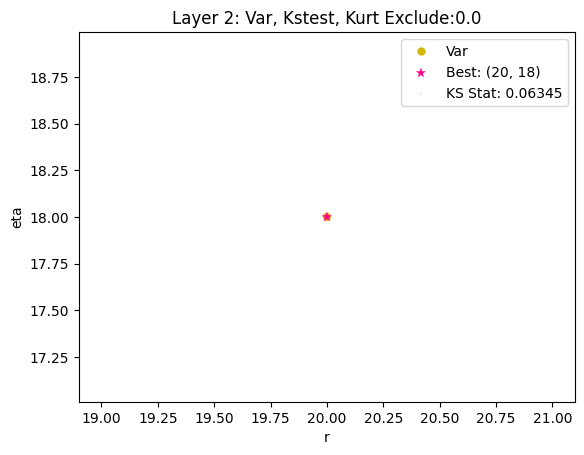

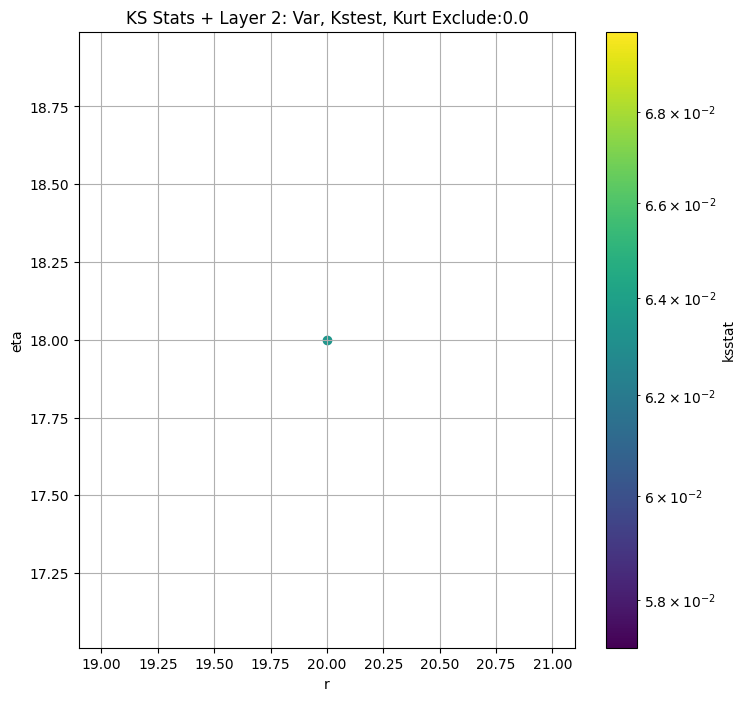

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.04839944352977055 1527.3071


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.04845043621751893 1451.2096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0484528847952147 1393.4138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0484955692037769 1341.2999


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.04851667996807674 1293.5765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.048557837175266405 1209.7272


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04936885986111478 1137.9031


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.05199476446261825 1073.5125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05581611711370926 1015.897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.061446975247101965 964.1863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.07679591397932539 830.4266
Number of samples: 9784, Without approximation : 9784


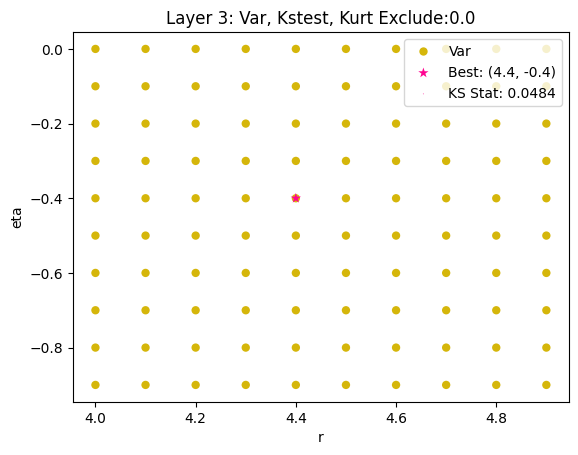

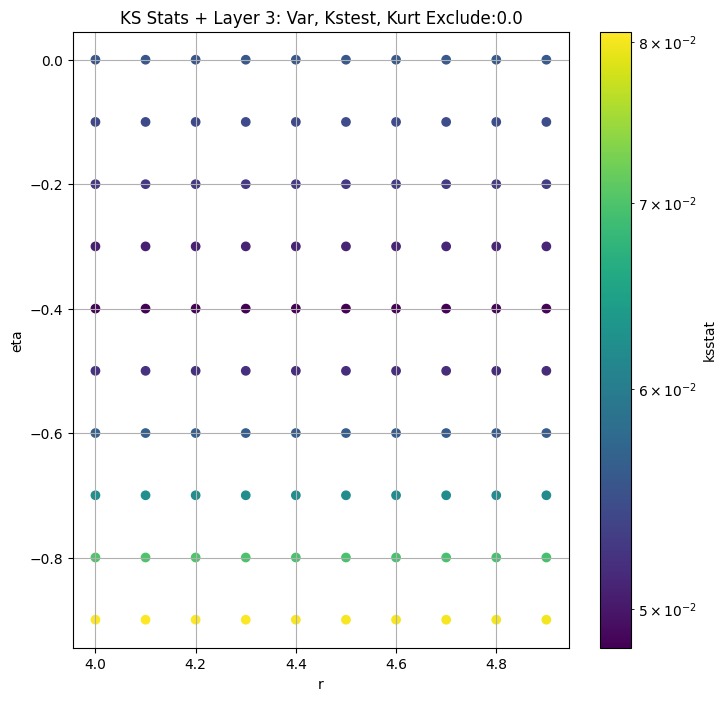

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03152125376025072 304.751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.031517096556415325 296.57236


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03151904153669588 290.471


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.03150932696912084 285.356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.03151188082437856 280.69803


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.03151873353791207 272.29233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.03151344665903277 264.6733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.03151570629631206 257.74408


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.0315144436441796 251.40694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.03151600306637986 245.56418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.031527112686647596 229.98877
Number of samples: 39136, Without approximation : 39136


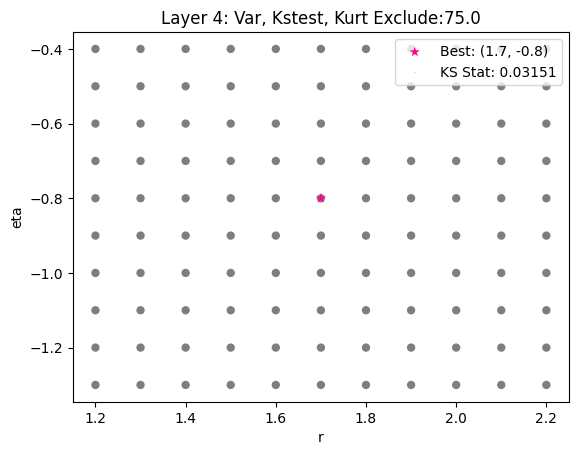

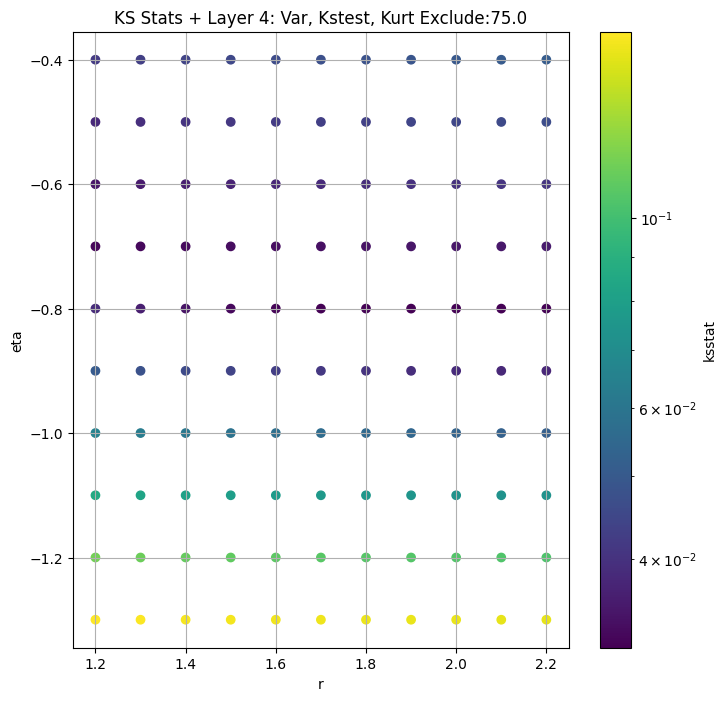

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.02654791013252028 59.79506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.026669396163382708 58.68362


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.026656159446567462 57.882576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.026644091777978274 57.16625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.02663294286729062 56.51601


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.026612610864032882 55.357933


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.026593871784249212 54.32128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.02657615304988148 53.36716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.02655984862645061 52.479412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.026547314105376196 51.645443


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.026625586517839694 49.389683
Number of samples: 100000, Without approximation : 156544


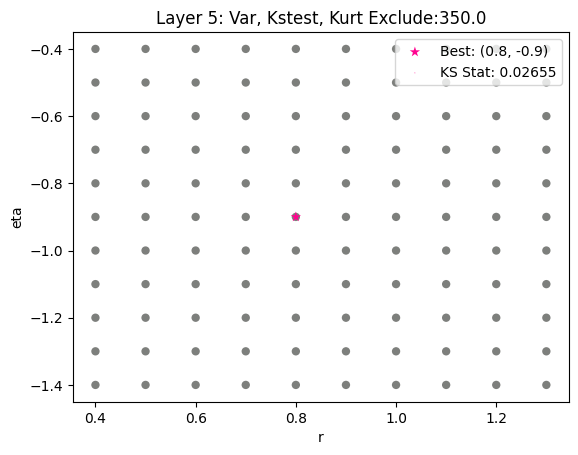

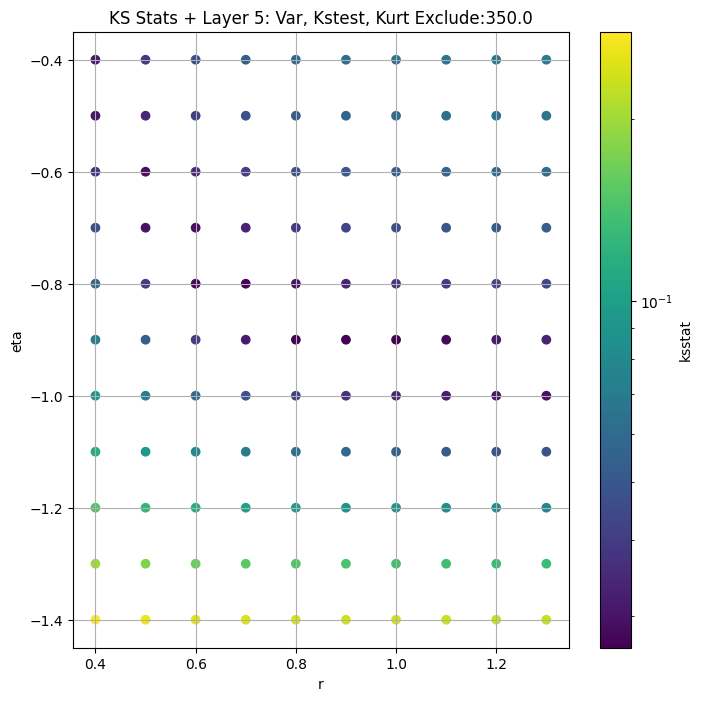

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.023863975245453417 11.827755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.02374839648270599 11.462891


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.023676660394265803 11.244309


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.023614413998360506 11.059329


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.023558012617573176 10.895359


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.02345648539702705 10.605324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.02414266139775334 10.349393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.024167059683620873 10.1166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.024090760935876032 9.902599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.024017525884489355 9.703161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.023811732913981754 9.172138
Number of samples: 100000, Without approximation : 626176


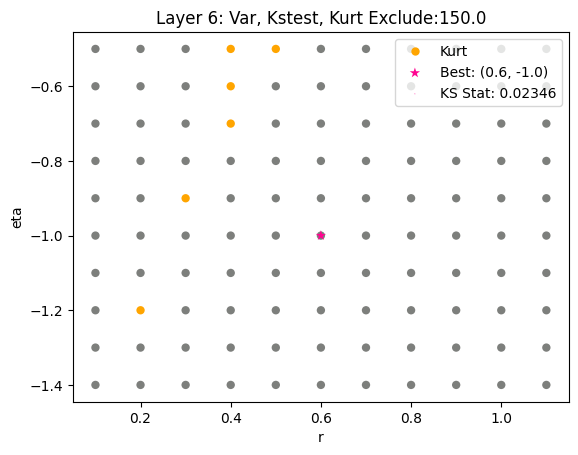

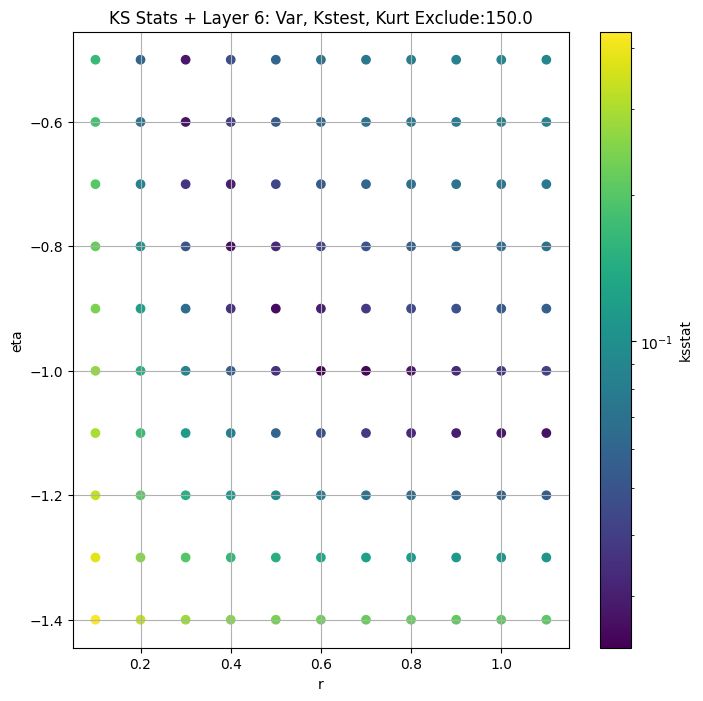

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02303192954755895 2.3825352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.023409965068907523 2.284714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02321757573903377 2.2298777


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02305174203261784 2.1840105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.022901039423362857 2.1434133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.022628267518996825 2.072455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.02238059015433952 2.0107136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.022265801243369188 1.9552463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.02303642433662212 1.9046156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.023215188591114877 1.8579105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.022664195348237548 1.7351799
Number of samples: 100000, Without approximation : 2504704


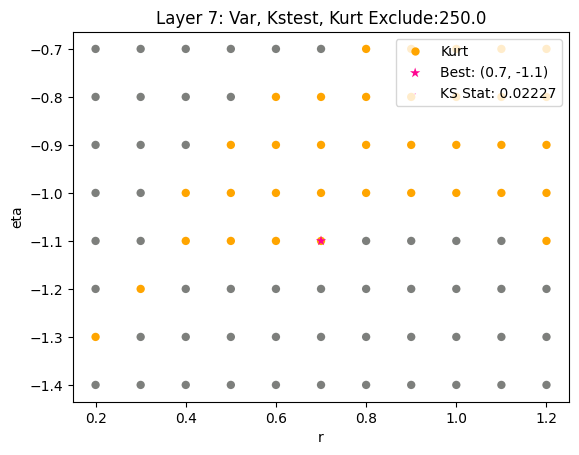

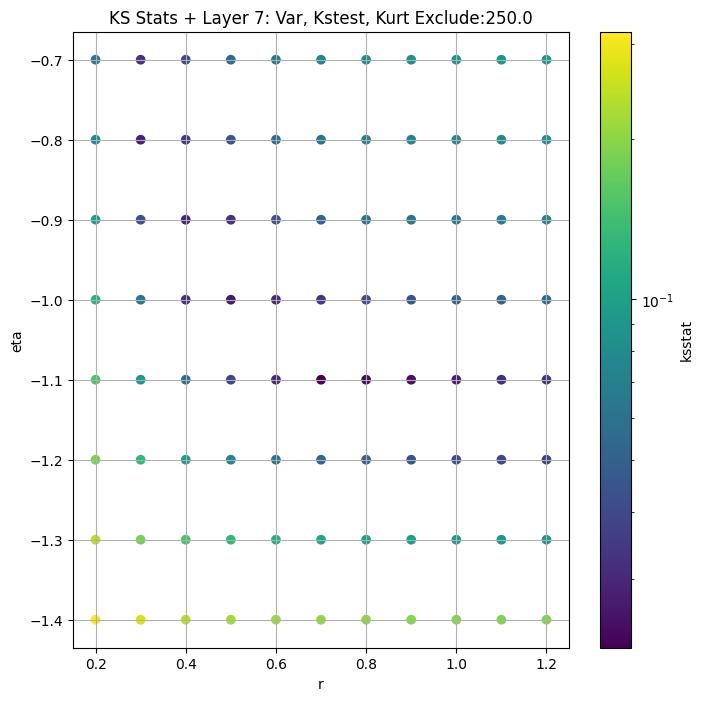

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.013105903634476335 0.53380805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.011630462690564392 0.50570184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.010878965236304994 0.49165788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.010433399873468918 0.47982183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011368536348729474 0.46934354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.012747879744001489 0.4511136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01141286940593289 0.43532255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.012366077206579118 0.42126638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.013316963207003152 0.4085395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.014264510727170387 0.39688662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.011567409132564821 0.3667494
Number of samples: 100000, Without approximation : 10018816


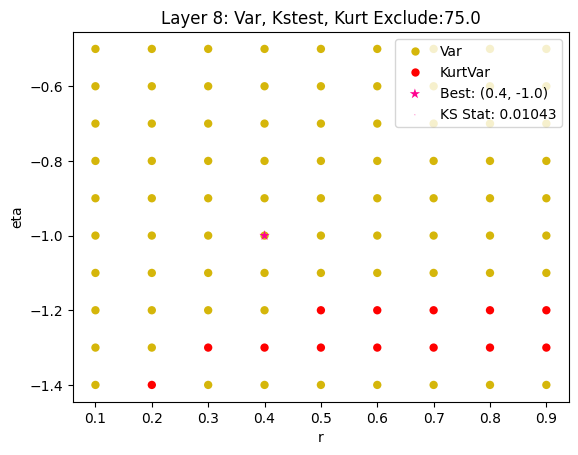

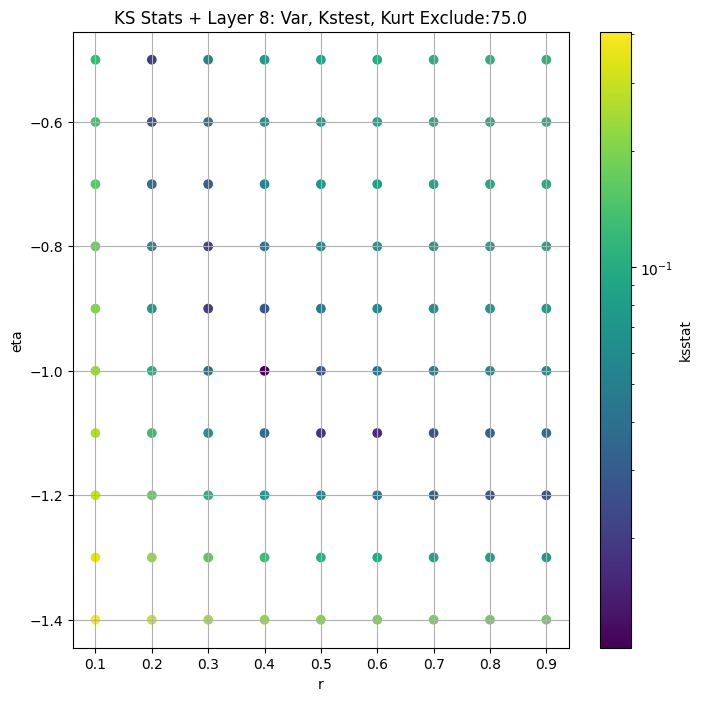

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.015500790408038922 0.1434037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.012873202146603258 0.13537621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.011659343626729601 0.13139053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.011863069177266428 0.12807596


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.012051409935377455 0.12515882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.01240221227753735 0.12009614


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.012734920740556821 0.11572811


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.012630965737938038 0.11185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.012121400433561913 0.10834658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.013641082107462288 0.10514375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.011168612732323058 0.09687861
Number of samples: 100000, Without approximation : 40075264


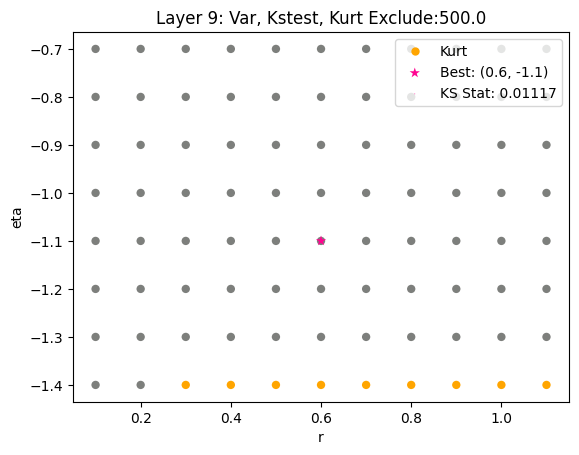

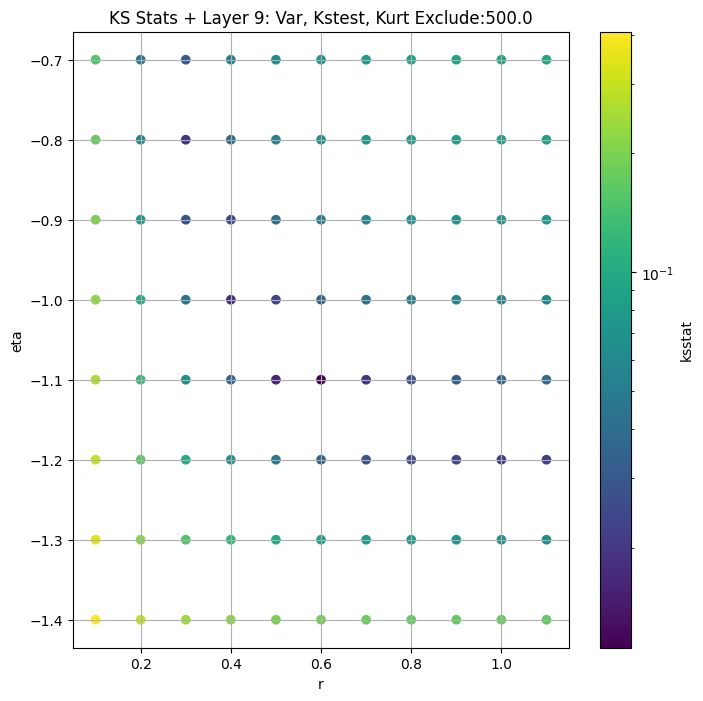

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7180.381000  6711.320300  7659.505400  -0.378304   -0.513872   
3      1527.307100  1463.583100  1592.961000   0.665273    0.523682   
4       304.751000   289.000060   320.981870   2.135894    1.794518   
5        59.795060    56.019490    63.707010   4.305979    3.588551   
6        11.827755    10.908563    12.835420   7.918665    5.803217   
7         2.382535     2.161930     2.647273  13.189318    8.213180   
8         0.533808     0.476204     0.618890  22.741901   10.412182   
9         0.143404     0.127543     0.167424  24.897825   11.187633   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.232905           2446             0.063450       20.0         18.0   
3        0.813738           9784             0.048399        4.4         -0.4   
4        2.511625          39136             0.031509        1.7         -0.8   
5        5.235517         156544             0.026547        0.8         -0.9   
6       14.427557         626176             0.023456        0.6         -1.0   
7       36.042410        2504704             0.022266        0.7         -1.1   
8       93.256430       10018816             0.010433        0.4         -1.0   
9       99.144640       40075264             0.011169        0.6         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7390.724255                     0.0         7180.381000   
3        2983.896385                     0.0         1527.307100   
4         614.479938                    75.0          285.356000   
5          63.287188                   350.0           51.645443   
6           9.005332                   150.0           10.605324   
7           3.047410                   250.0            1.955246   
8           0.098330                    75.0            0.479822   
9           0.110180                   500.0            0.096879   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.1040678647995884, var: 5066.17041015625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.09498875812589869, var: 5462.3369140625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.08551810999442944, var: 5910.90576171875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.07496315855181235, var: 6458.994140625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.06344980493519309, var: 7180.380859375
Number of samples: 2446, Without approximation : 2446


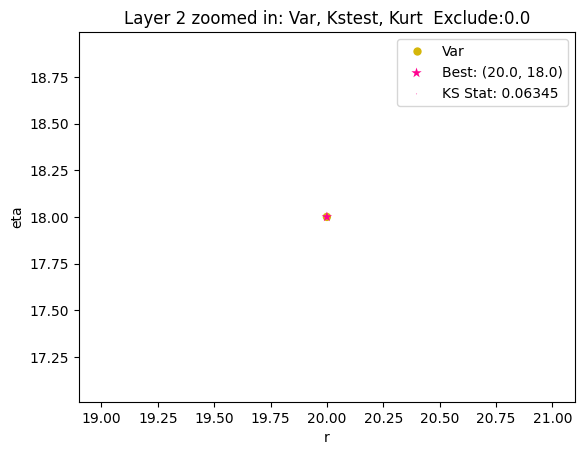

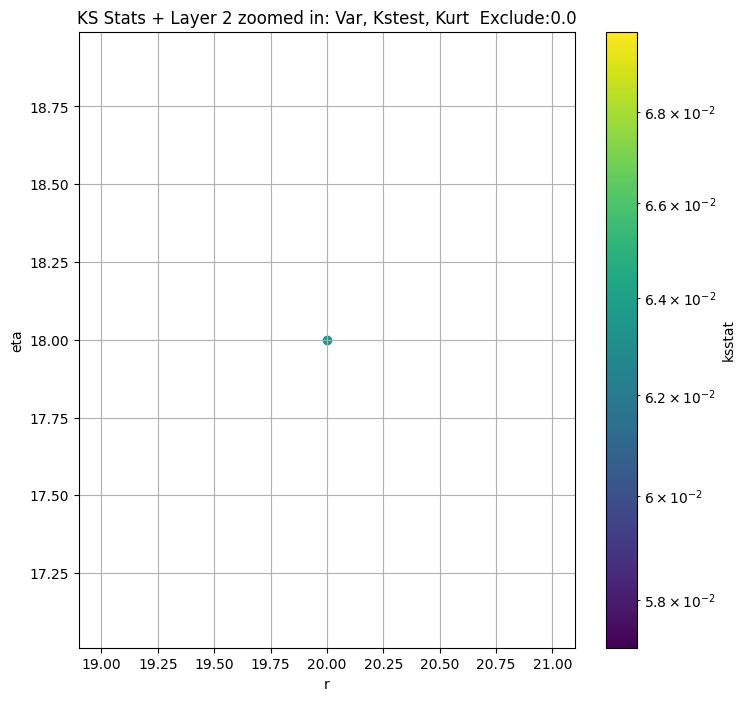

Layer 3


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.04853883234929185, var: 1293.5765380859375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.0484955692037769, var: 1341.2999267578125


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.0485176294674563, var: 1393.413818359375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.04845301879100927, var: 1451.2095947265625


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.04839944352977055, var: 1527.30712890625
Number of samples: 9784, Without approximation : 9784


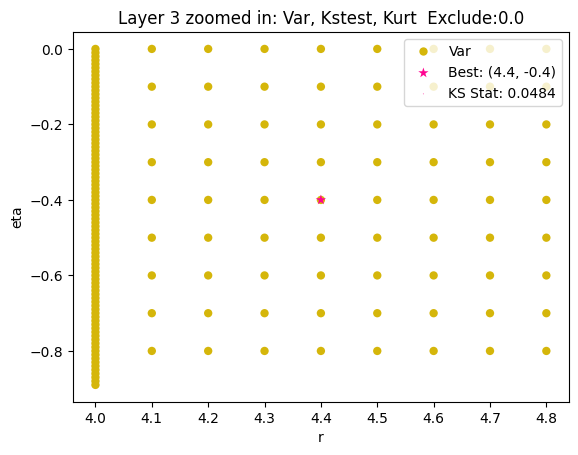

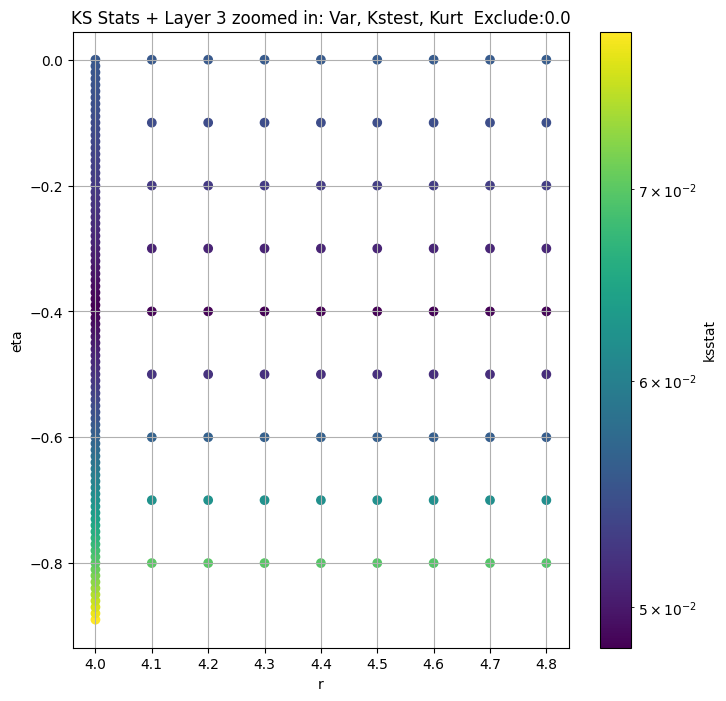

Layer 4


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + 100 = 175, ksstat: 0.031514099041400456, var: 268.3782958984375


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + 75 = 150, ksstat: 0.03150989615862748, var: 272.2923278808594


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + 50 = 125, ksstat: 0.031509614903276806, var: 276.3858337402344


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + 25 = 100, ksstat: 0.03150733224498009, var: 280.6980285644531


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + 0 = 75, ksstat: 0.03150746389210418, var: 285.3559875488281


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + -25 = 50, ksstat: 0.031496589937530184, var: 290.47100830078125


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + -50 = 25, ksstat: 0.031488714478670965, var: 296.5723571777344


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 75.0 + -75 = 0, ksstat: 0.031483020333196, var: 304.7510070800781
Number of samples: 39136, Without approximation : 39136


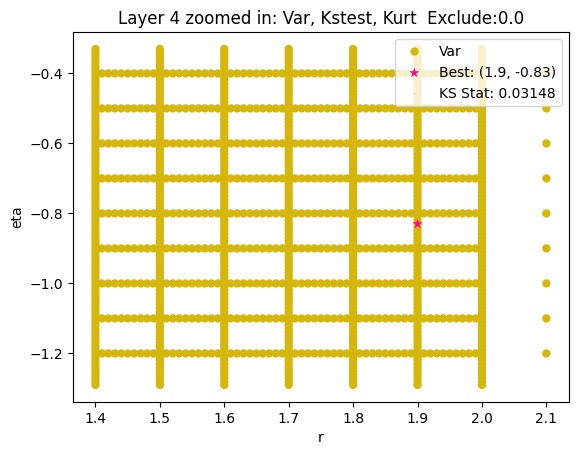

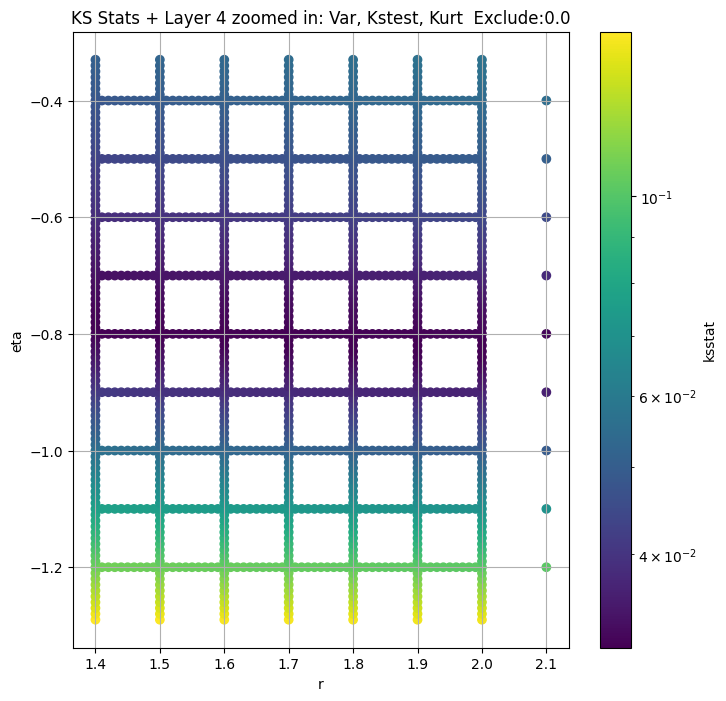

Layer 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.026468844466716324, var: 50.1050910949707


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.026475130808822078, var: 50.475563049316406


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.026443221687909246, var: 50.85554885864258


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.026402055857327966, var: 51.24549102783203


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.026408932582842604, var: 51.645442962646484


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.02641592024268491, var: 52.05653762817383


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.02642302445486322, var: 52.47941207885742


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.0264302674219426, var: 52.91573715209961


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.026437669658519014, var: 53.36716079711914
Number of samples: 100000, Without approximation : 156544


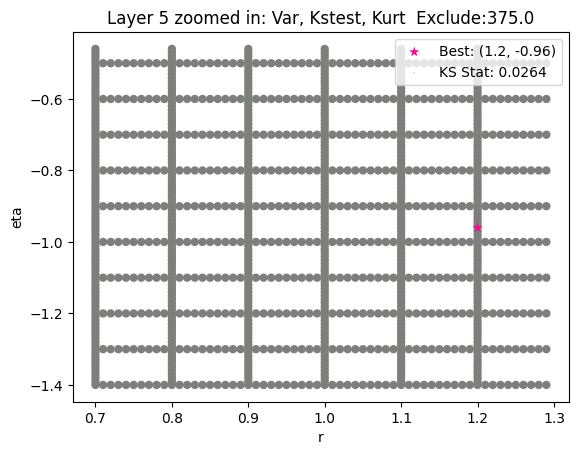

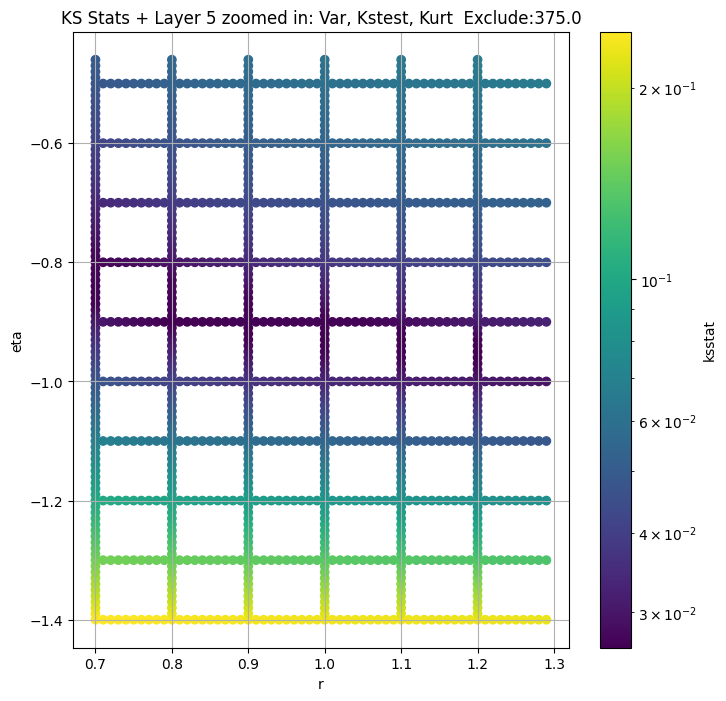

Layer 6


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.022921244465443746, var: 10.116600036621094


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.02296325476583111, var: 10.230361938476562


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.02313964414359332, var: 10.349392890930176


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.023184806112294676, var: 10.473908424377441


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.023231922893417634, var: 10.605323791503906


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.023281159445001753, var: 10.745189666748047


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.023142825769154163, var: 10.89535903930664


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.022959889505374975, var: 11.05932903289795


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.02311511611626149, var: 11.244309425354004
Number of samples: 100000, Without approximation : 626176


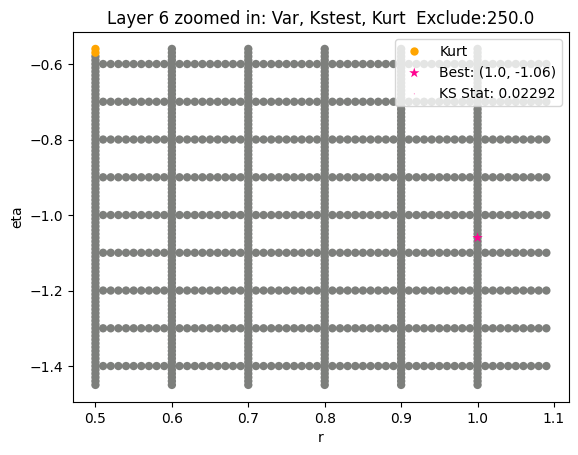

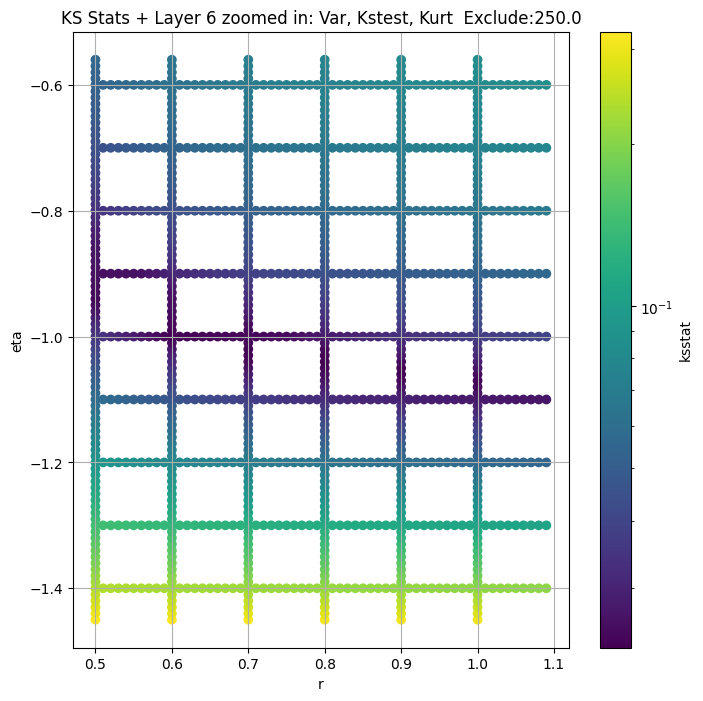

Layer 7


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.020966446059315746, var: 1.8579105138778687


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.02076231951510804, var: 1.8808106184005737


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.020865620180076094, var: 1.9046156406402588


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.020971359441066206, var: 1.9294029474258423


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.021079679360184178, var: 1.9552463293075562


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.021191028055668637, var: 1.982299566268921


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.020935681694224217, var: 2.010713577270508


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.020743231169903953, var: 2.040656805038452


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.020868063718065932, var: 2.0724549293518066
Number of samples: 100000, Without approximation : 2504704


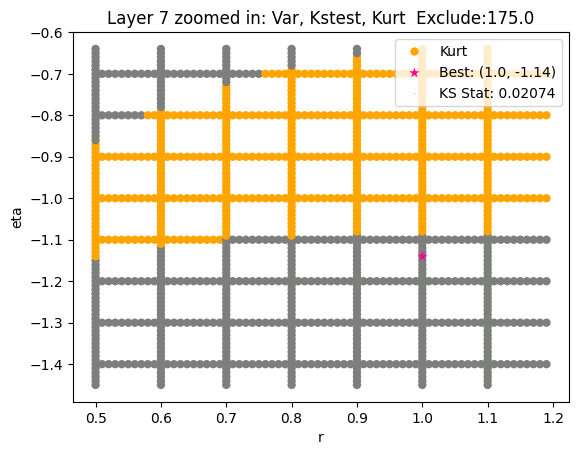

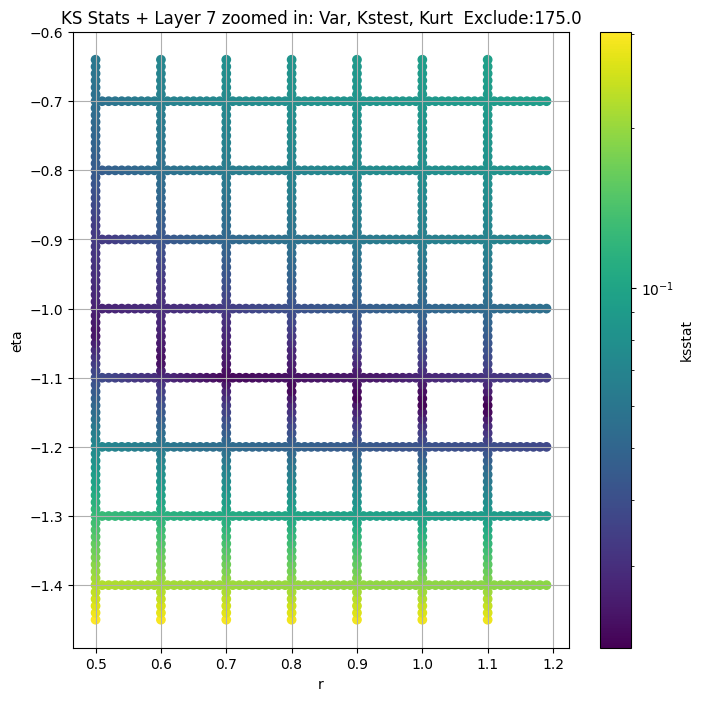

Layer 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.010901712520363649, var: 0.4429665505886078


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.010311191396231711, var: 0.45111361145973206


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.010313145870426532, var: 0.4598482847213745


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.011113925303495142, var: 0.46934354305267334


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.010433399873468918, var: 0.4798218309879303


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.010878965236304994, var: 0.49165788292884827


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.010425997781627783, var: 0.5057018399238586


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.010499266068906832, var: 0.5338080525398254
Number of samples: 100000, Without approximation : 10018816


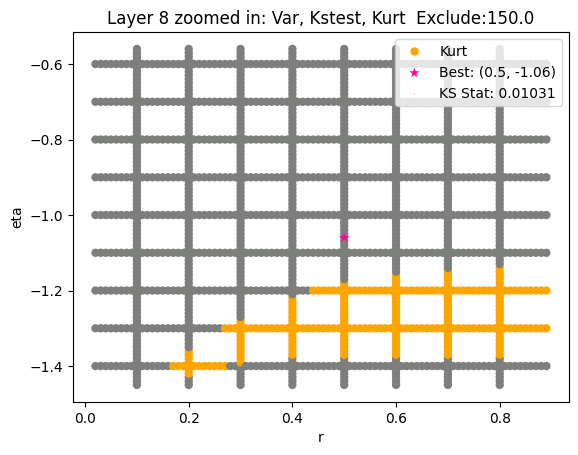

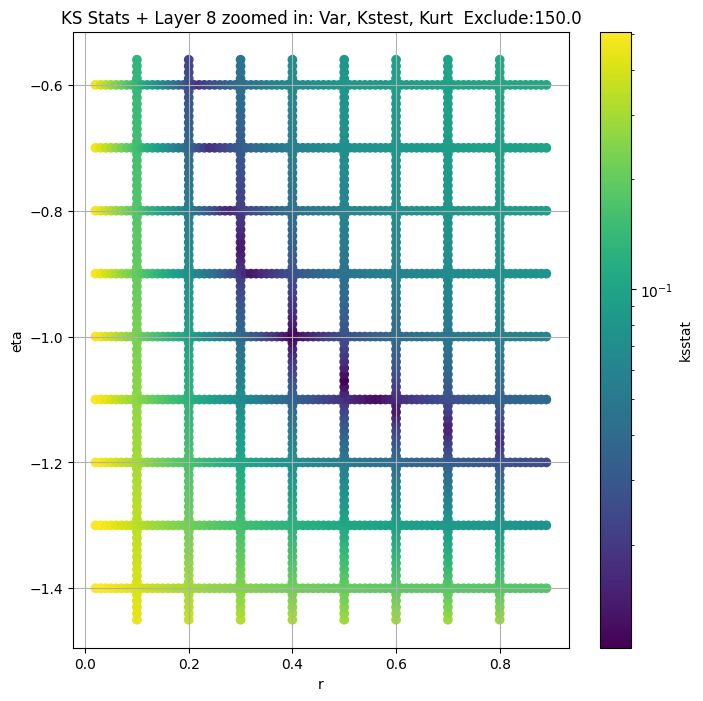

Layer 9


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.011923120125118536, var: 0.09220511466264725


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.011558965975760657, var: 0.0933222696185112


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.011308679918805374, var: 0.09447238594293594


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.011266385389969713, var: 0.0956571027636528


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.011168612732323058, var: 0.09687861055135727


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.01130563969447318, var: 0.09813959151506424


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.011204014027806575, var: 0.09944283962249756


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.011345441247955113, var: 0.10079143196344376


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.01100756268719083, var: 0.10218840837478638
Number of samples: 100000, Without approximation : 40075264


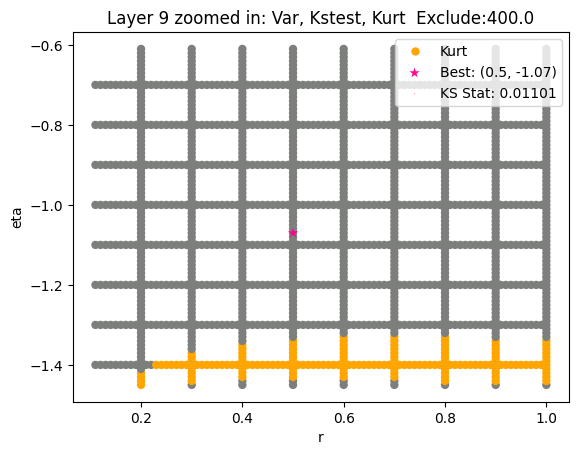

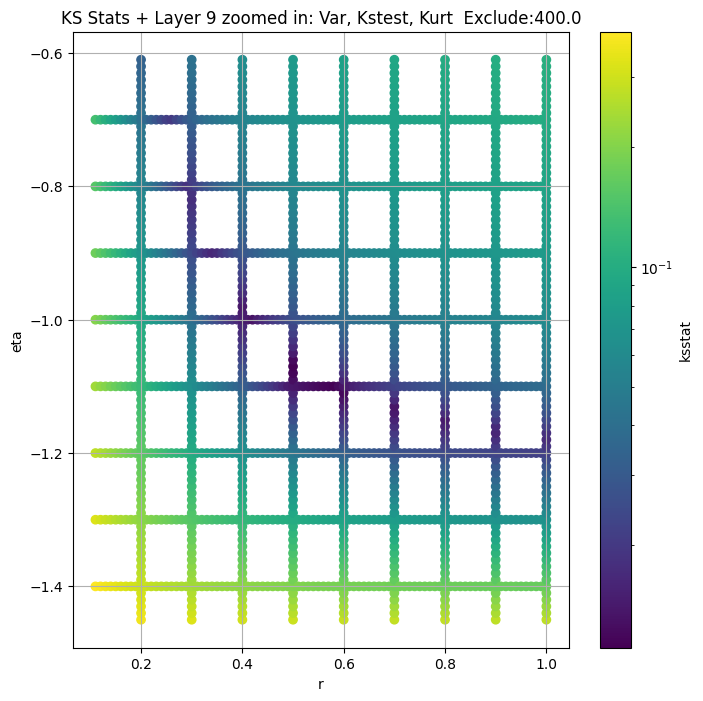

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7180.381000  6711.320300  7659.505400  -0.378304   -0.513872   
3      1527.307100  1463.583100  1592.961000   0.665273    0.523682   
4       304.751000   289.000060   320.981870   2.135894    1.794518   
5        59.795060    56.019490    63.707010   4.305979    3.588551   
6        11.827755    10.908563    12.835420   7.918665    5.803217   
7         2.382535     2.161930     2.647273  13.189318    8.213180   
8         0.533808     0.476204     0.618890  22.741901   10.412182   
9         0.143404     0.127543     0.167424  24.897825   11.187633   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.232905           2446             0.063450       20.0         18.0   
3        0.813738           9784             0.048399        4.4         -0.4   
4        2.511625          39136             0.031509        1.7         -0.8   
5        5.235517         156544             0.026547        0.8         -0.9   
6       14.427557         626176             0.023456        0.6         -1.0   
7       36.042410        2504704             0.022266        0.7         -1.1   
8       93.256430       10018816             0.010433        0.4         -1.0   
9       99.144640       40075264             0.011169        0.6         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7390.724255                     0.0         7180.381000   
3        2983.896385                     0.0         1527.307100   
4         614.479938                    75.0          304.751007   
5          63.287188                   350.0           51.245491   
6           9.005332                   150.0           10.116600   
7           3.047410                   250.0            2.040657   
8           0.098330                    75.0            0.451114   
9           0.110180                   500.0            0.102188   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.063450    20.0     18.00   
3                     0.013713          0.048399     4.4     -0.40   
4                     0.006861          0.031483     1.9     -0.83   
5                     0.003431          0.026402     1.2     -0.96   
6                     0.001716          0.022921     1.0     -1.06   
7                     0.000858          0.020743     1.0     -1.14   
8                     0.000429          0.010311     0.5     -1.06   
9                     0.000215          0.011008     0.5     -1.07   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      7390.724255                  0.0          457  
3      2983.896385                  0.0          772  
4       708.811056                  0.0         1834  
5       112.046194                375.0         2751  
6        22.992273                250.0         3669  
7         5.668491                175.0         4126  
8         0.272675                150.0        16510  
9         0.063884                400.0        14676

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

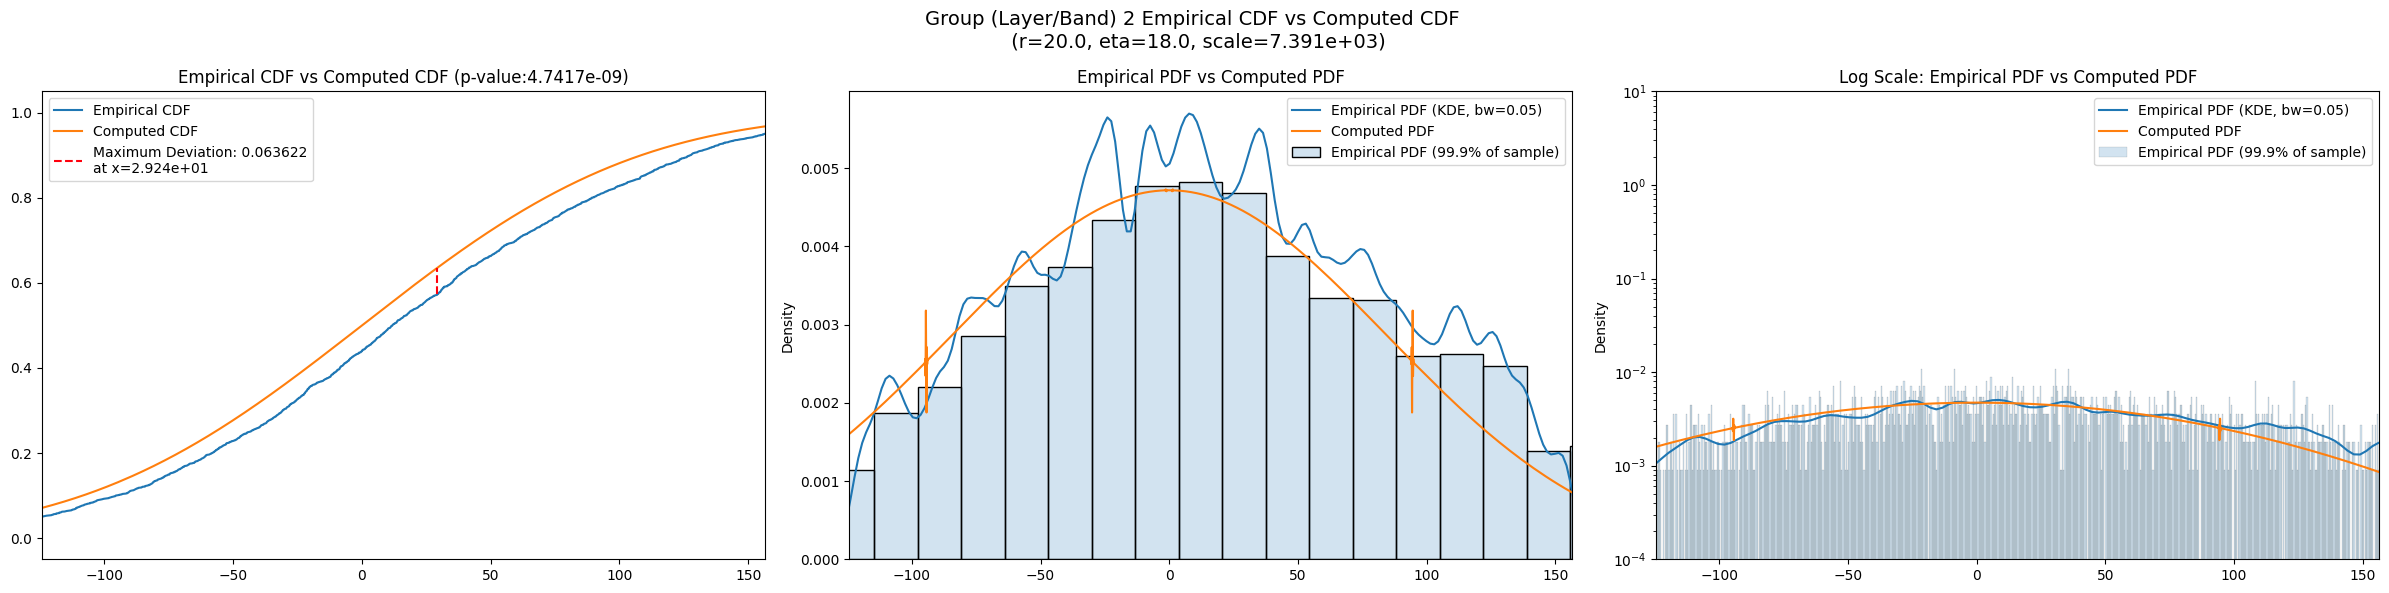

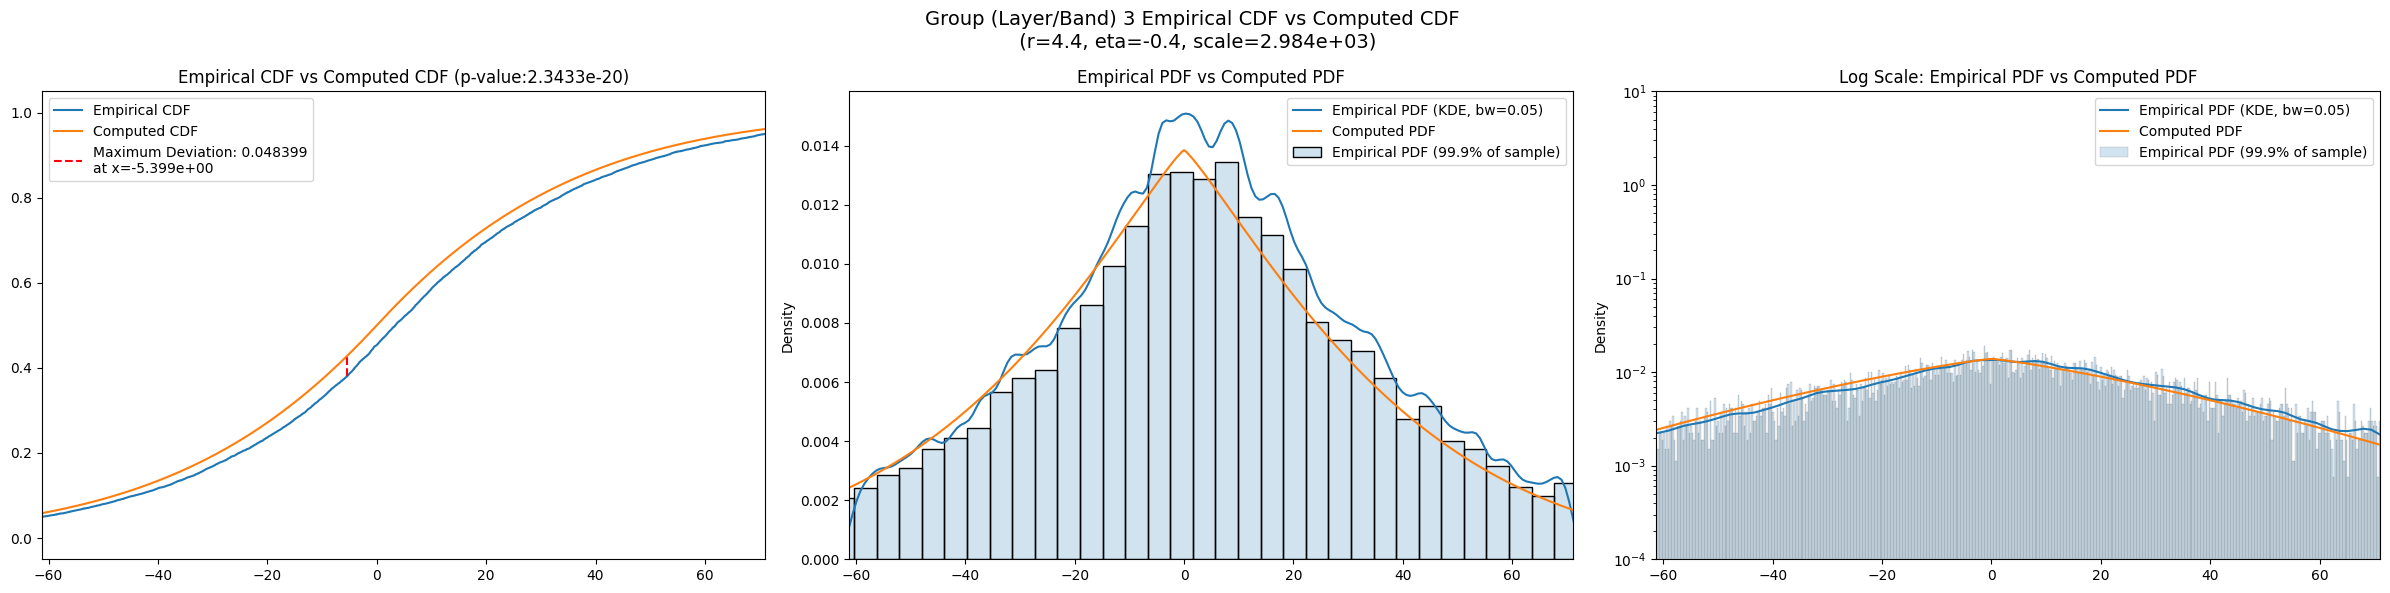

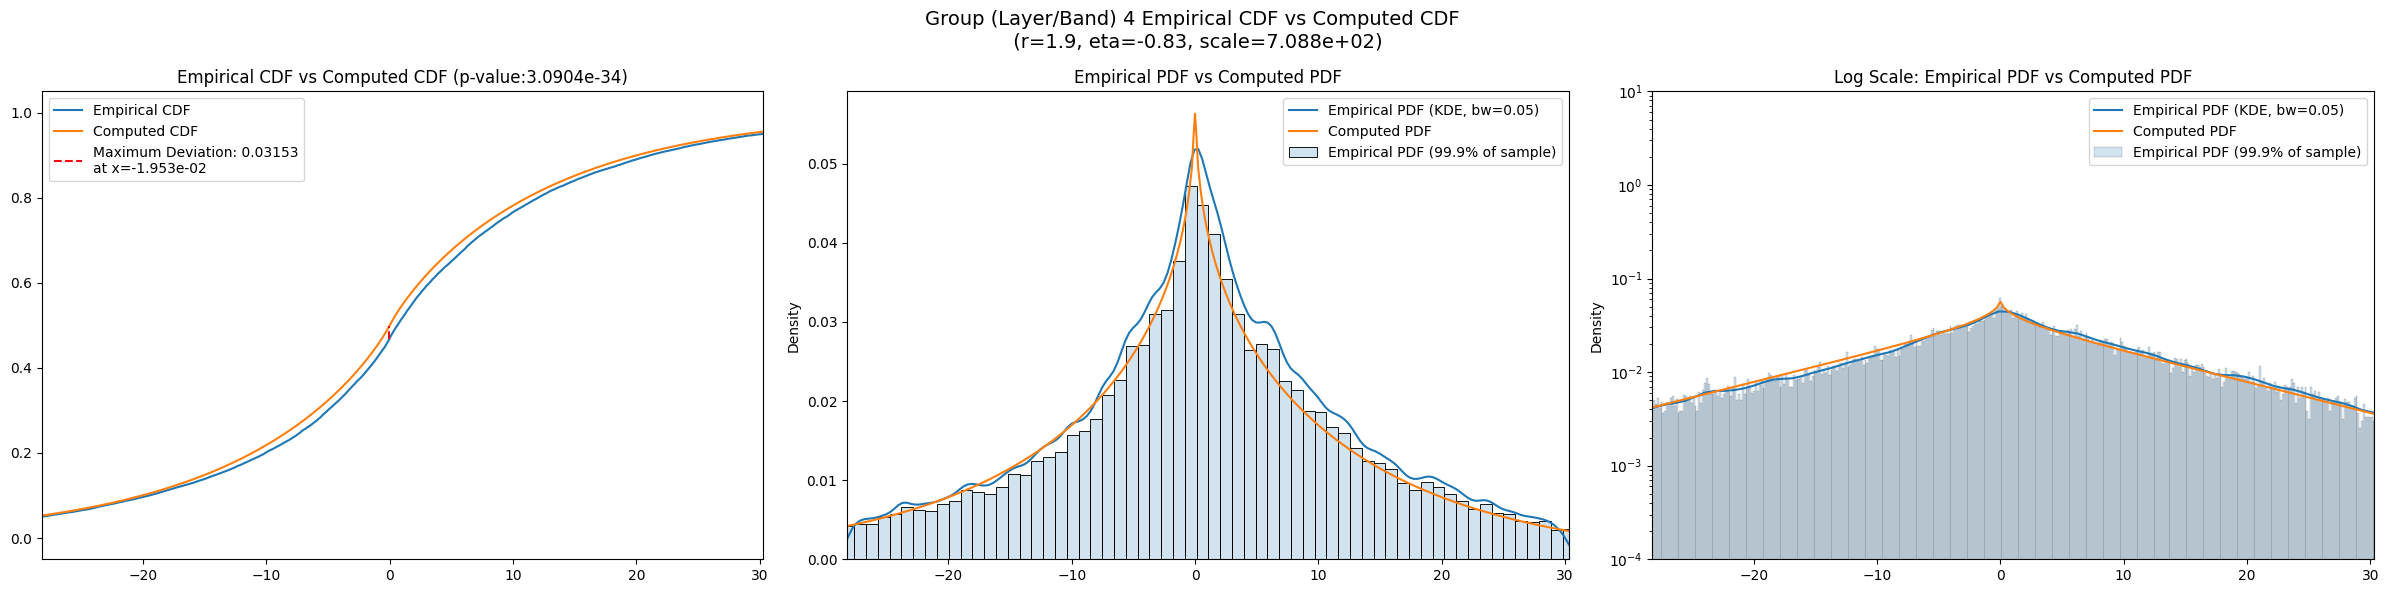

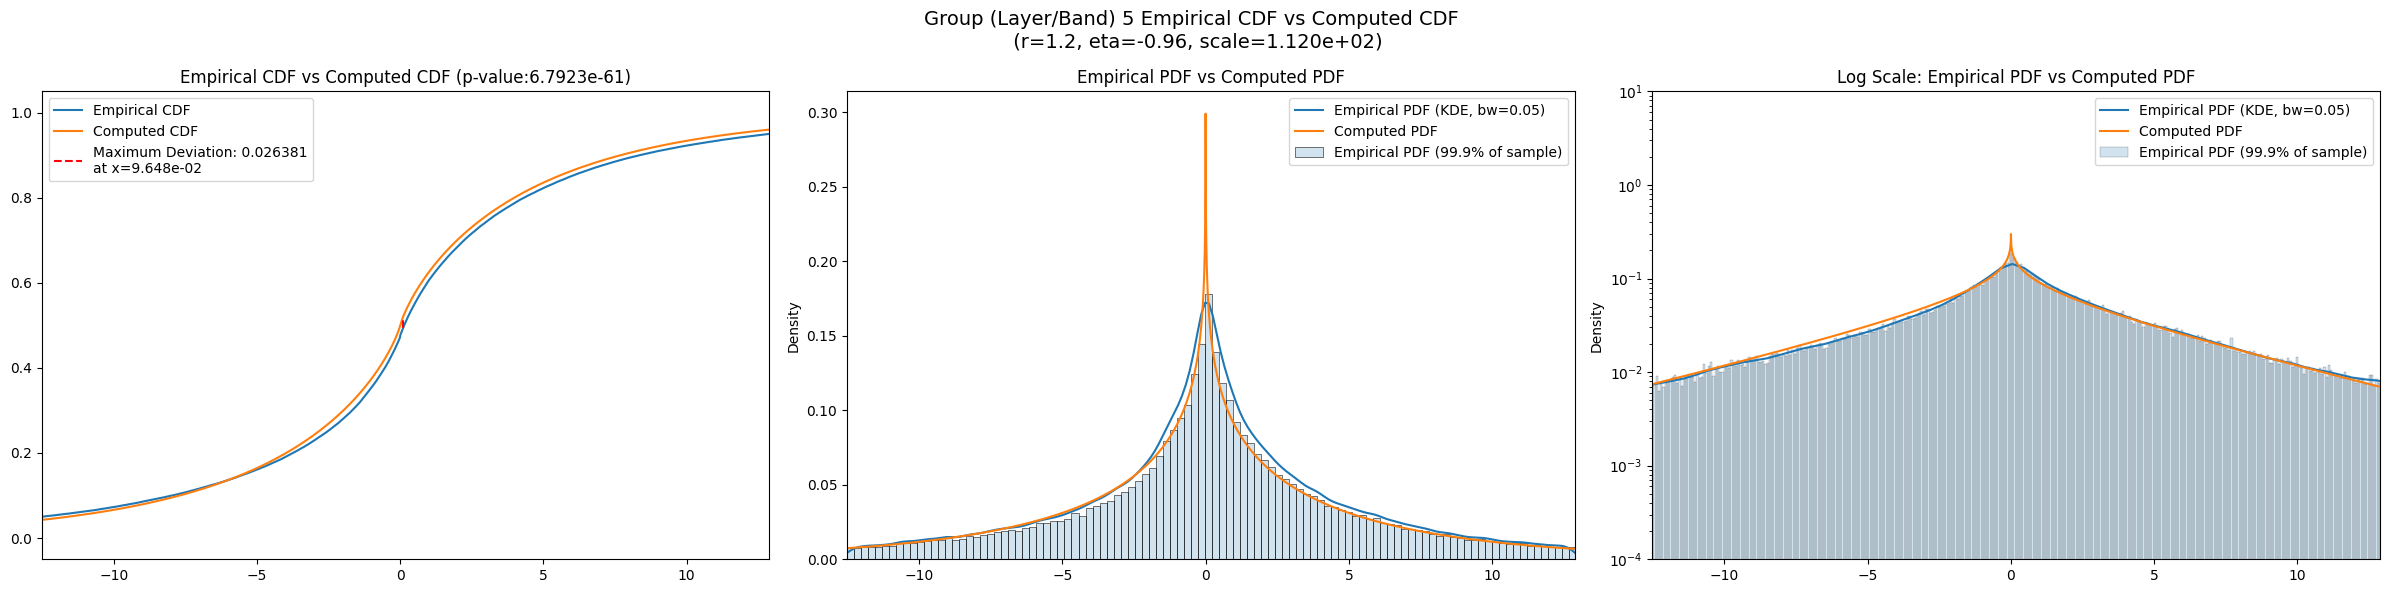

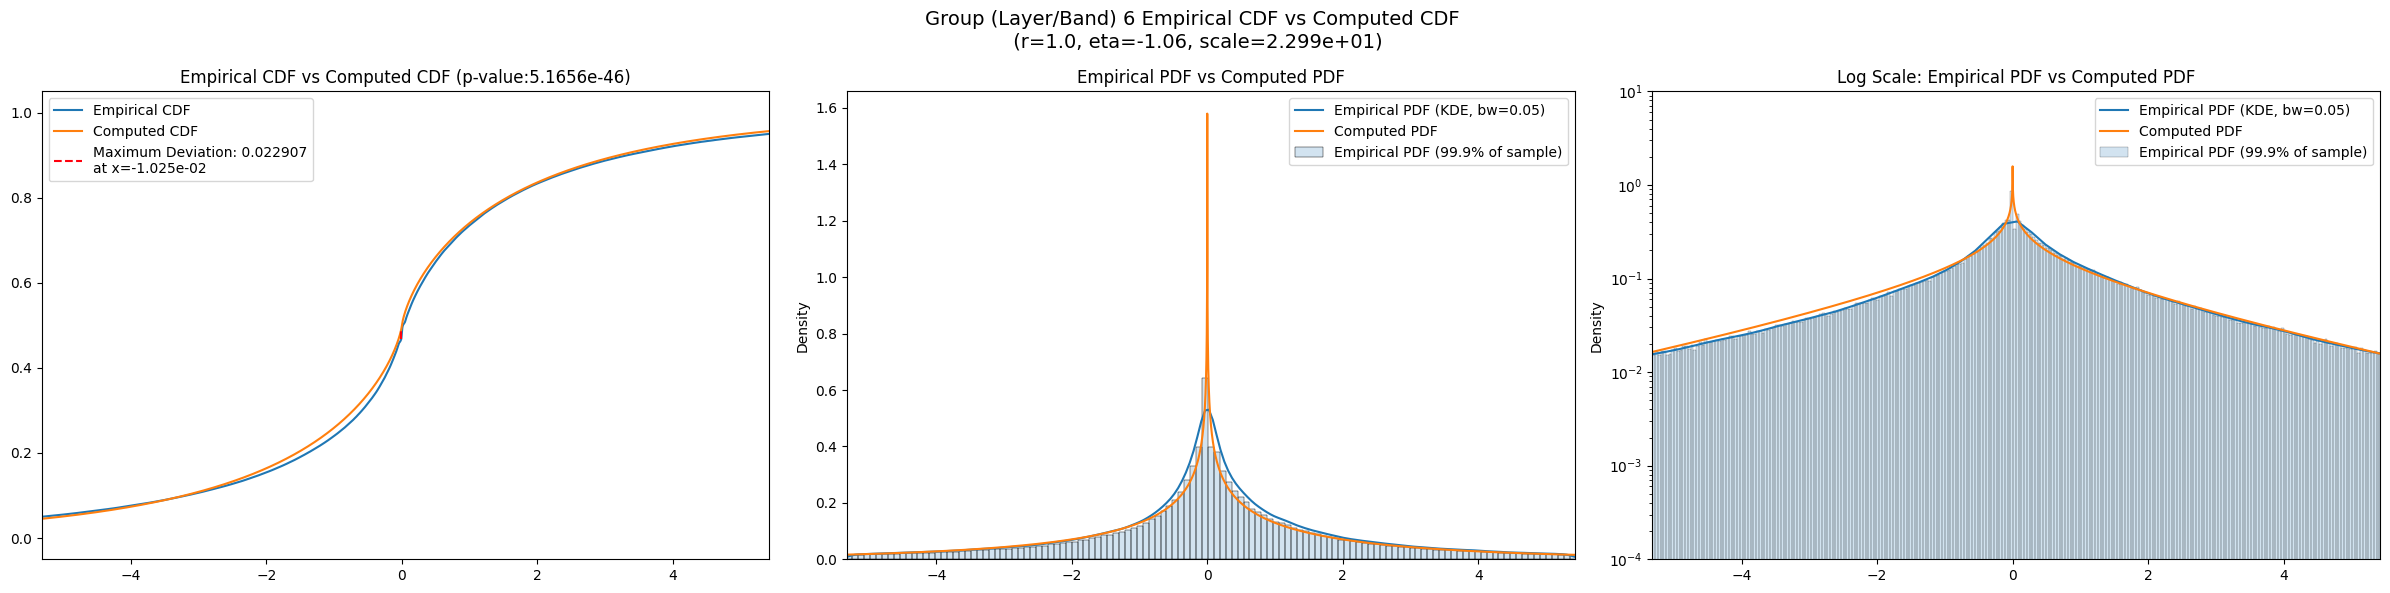

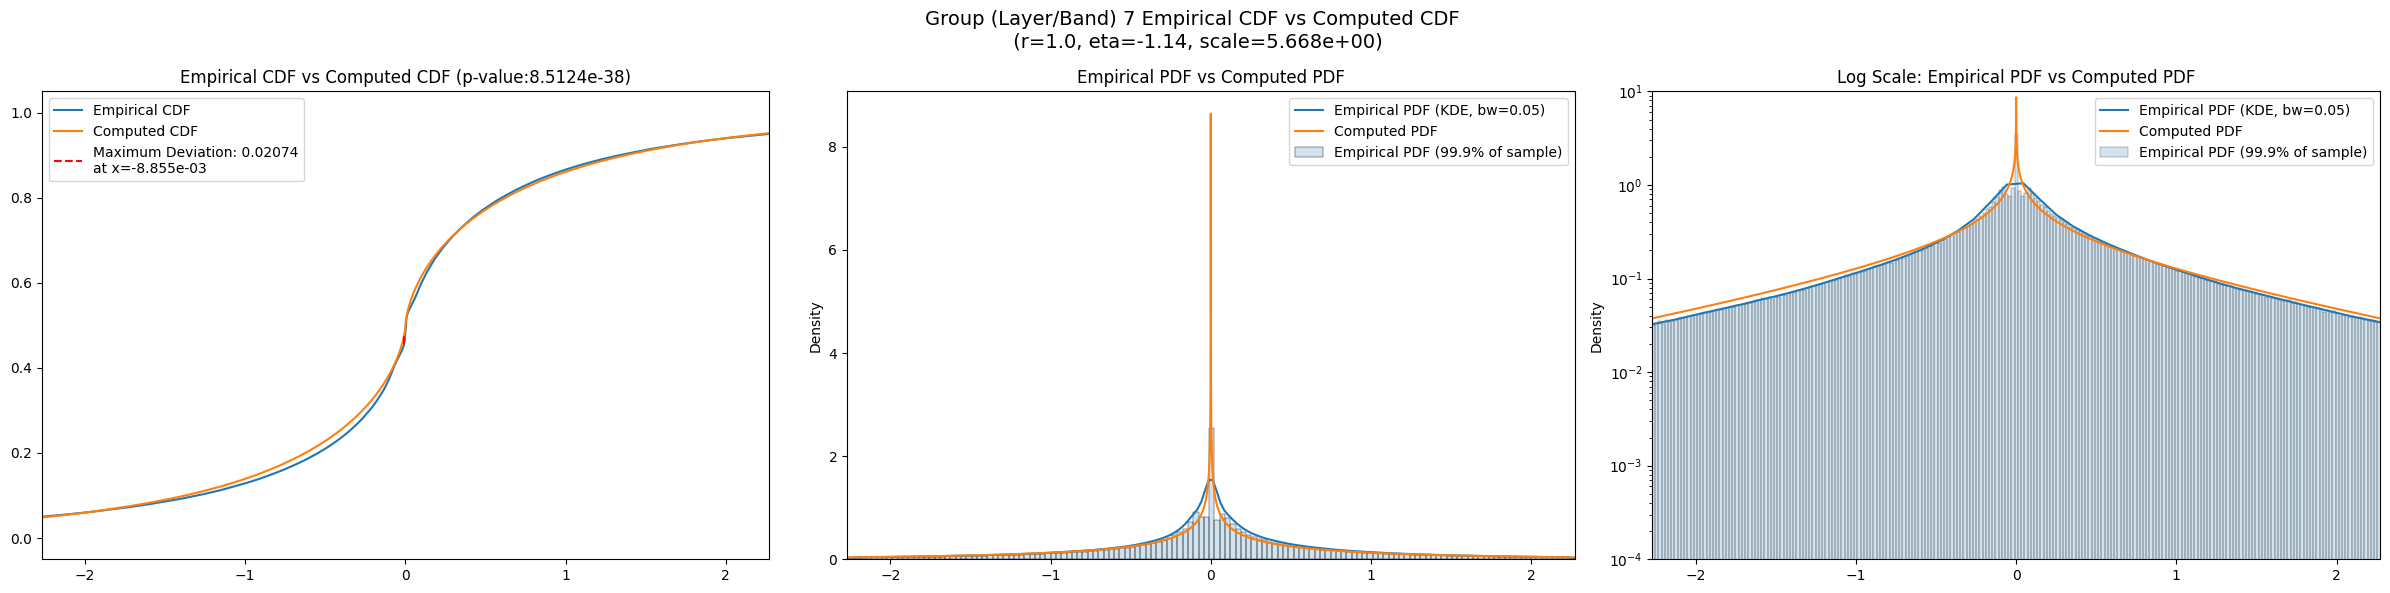

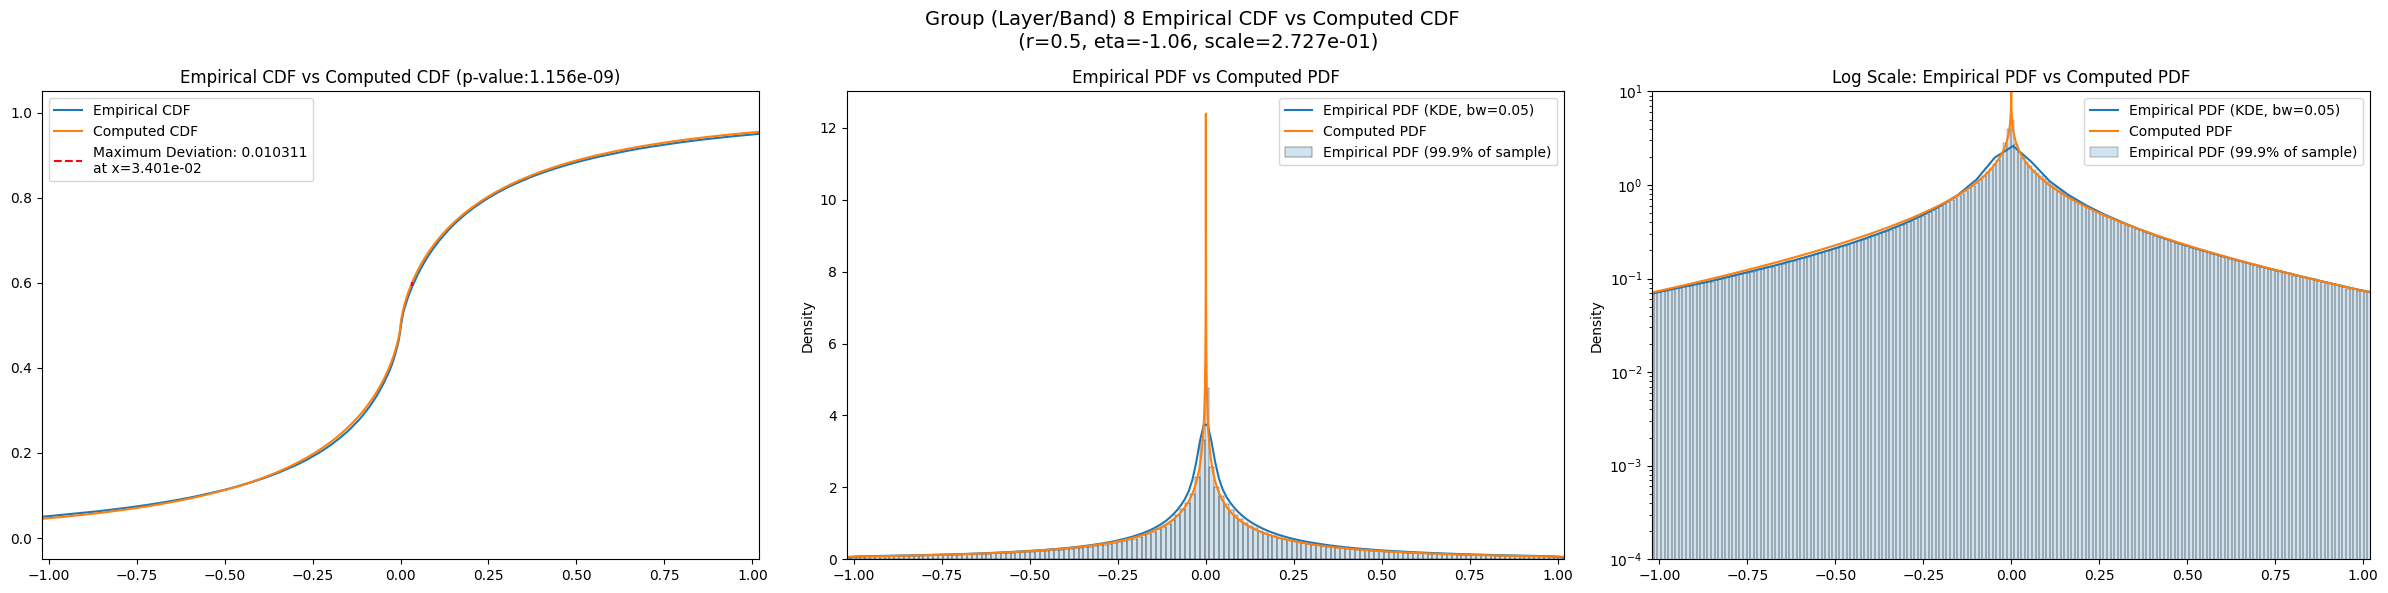

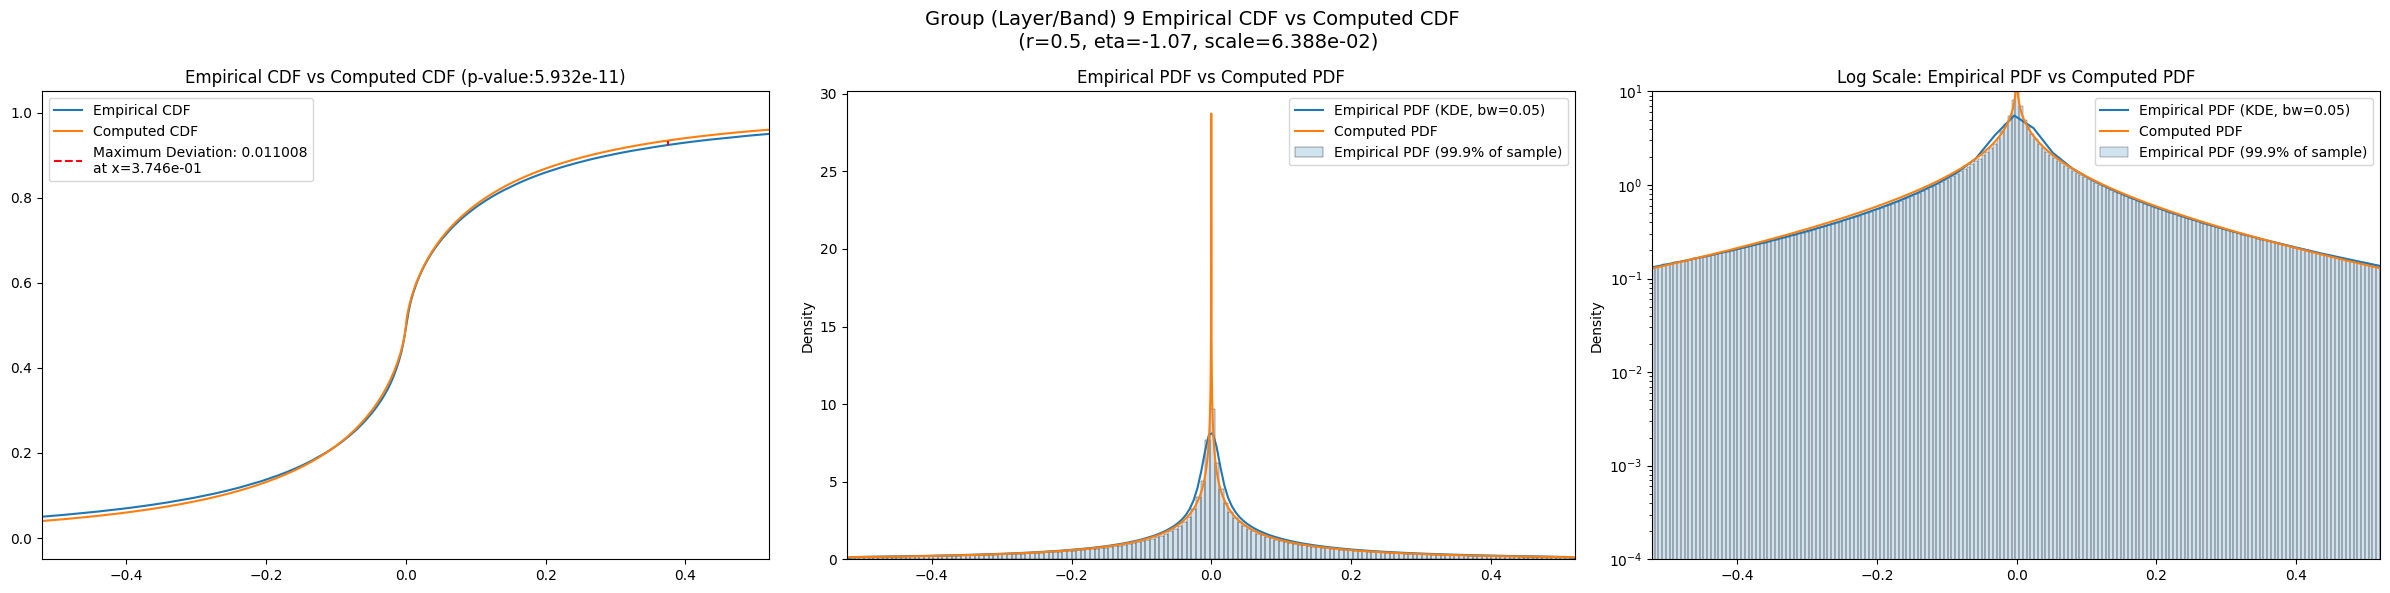

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7180.381000  6711.320300  7659.505400  -0.378304   -0.513872   
3      1527.307100  1463.583100  1592.961000   0.665273    0.523682   
4       304.751000   289.000060   320.981870   2.135894    1.794518   
5        59.795060    56.019490    63.707010   4.305979    3.588551   
6        11.827755    10.908563    12.835420   7.918665    5.803217   
7         2.382535     2.161930     2.647273  13.189318    8.213180   
8         0.533808     0.476204     0.618890  22.741901   10.412182   
9         0.143404     0.127543     0.167424  24.897825   11.187633   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.232905           2446             0.063450       20.0         18.0   
3        0.813738           9784             0.048399        4.4         -0.4   
4        2.511625          39136             0.031509        1.7         -0.8   
5        5.235517         156544             0.026547        0.8         -0.9   
6       14.427557         626176             0.023456        0.6         -1.0   
7       36.042410        2504704             0.022266        0.7         -1.1   
8       93.256430       10018816             0.010433        0.4         -1.0   
9       99.144640       40075264             0.011169        0.6         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       84.680300              0.063512          5.076790e-09   
3      ...       32.195200              0.053504          8.766900e-25   
4      ...       12.850100              0.051160          1.834650e-89   
5      ...        4.704770              0.063100          0.000000e+00   
6      ...        1.756630              0.071737          0.000000e+00   
7      ...        0.687490              0.074713          0.000000e+00   
8      ...        0.297378              0.075810          0.000000e+00   
9      ...        0.143751              0.079160          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          86.996000             0.071175         3.210200e-11  72.690500   
3          34.789800             0.048218         3.305630e-20  26.419600   
4          11.037300             0.033513         1.266850e-38   9.314640   
5           4.038300             0.037688        1.250880e-193   3.322620   
6           1.506510             0.045879         0.000000e+00   1.208150   
7           0.590208             0.048957         0.000000e+00   0.468300   
8           0.254860             0.050459         0.000000e+00   0.199778   
9           0.122605             0.054484         0.000000e+00   0.095707   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.065239   1.705390e-09          5.278292e-09  
3           0.048581   1.660480e-20          2.343276e-20  
4           0.038267   3.124150e-50          3.902834e-34  
5           0.043292  2.211580e-255          3.138726e-95  
6           0.049733   0.000000e+00         3.240028e-286  
7           0.051400   0.000000e+00          0.000000e+00  
8           0.052646   0.000000e+00          0.000000e+00  
9           0.056316   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.063450                 0.027391          0.063450   
3                 0.048399                 0.013713          0.048399   
4                 0.031509                 0.006861          0.031483   
5                 0.026547                 0.003431          0.026402   
6                 0.023456                 0.001716          0.022921   
7                 0.022266                 0.000858          0.020743   
8                 0.010433                 0.000429          0.010311   
9                 0.011169                 0.000215          0.011008   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.063512             0.071175       0.065239  
3                  0.053504             0.048218       0.048581  
4                  0.051160             0.033513       0.038267  
5                  0.063100             0.037688       0.043292  
6                  0.071737             0.045879       0.049733  
7                  0.074713             0.048957       0.051400  
8                  0.075810             0.050459       0.052646  
9                  0.079160             0.054484       0.056316

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             7180.381000          0.063450    20.0     18.00  7390.724255   
3             1527.307100          0.048399     4.4     -0.40  2983.896385   
4              304.751007          0.031483     1.9     -0.83   708.811056   
5               51.245491          0.026402     1.2     -0.96   112.046194   
6               10.116600          0.022921     1.0     -1.06    22.992273   
7                2.040657          0.020743     1.0     -1.14     5.668491   
8                0.451114          0.010311     0.5     -1.06     0.272675   
9                0.102188          0.011008     0.5     -1.07     0.063884   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    375.0  
6                    250.0  
7                    175.0  
8                    150.0  
9                    400.0

In [21]:
eng.quit()